# Bibliotecas Utilizadas:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from PyEMD import EMD

from PyEMD import EEMD

from PyEMD import CEEMDAN
#from sklearn.metrics import mean_squared_error
#from scipy.stats import pearsonr

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Previsão com SARIMAX

import pmdarima as pm
import statsmodels.api as sm

In [3]:
# Previsão com Prophet

from prophet import Prophet

In [4]:
# Previsão com LASSO

from sklearn.linear_model import Lasso

# Import dos Dados:

Fonte: https://www.kaggle.com/datasets/sc231997/crude-oil-price

In [5]:
%%time

df = pd.read_csv('crude-oil-price.csv')

CPU times: total: 0 ns
Wall time: 4 ms


# Funções Utilizadas:

In [6]:
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(8,5))
    plt.xticks(rotation=90)
    fig=sns.barplot(ms.index, ms["Percent"],color="green",alpha=0.8)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    return ms

In [7]:
def TratamentoDados(df=df, ncol=5):
    df_train = None
    df_train = pd.DataFrame()
    zero_fill=[0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    n=0
    while n is not ncol:    
        df_train[f'x{n+1}'] = df['Value'][(n):].reset_index(drop=True).to_list() + zero_fill[:n]
        n = n + 1
    df_train['y'] = df['Value'][(n):].reset_index(drop=True).to_list() + zero_fill[:n]
    df_train = df_train[:-n]
    return df_train

In [8]:
df_func = None

def SARIMAX_EMD_FUNC(df_f=df_func):
    df_train_func = df_f[:-60]
    df_test_func = df_f[-60:]
    model_sx = pm.auto_arima(df_train_func[1:], seasonal=True, m=12, trace=False)
    k = str(model_sx)
    k1 = int(k[7])
    k2 = int(k[9])
    k3 = int(k[11])
    k4 = int(k[14])
    k5 = int(k[16])
    k6 = int(k[18])
    k7 = int(k[21:23])
    model_sx = sm.tsa.statespace.SARIMAX(df_train_func[1:],
                                         order=(k1, k2, k3),
                                         seasonal_order=(k4, k5, k6, k7))
    model_sx_fit = model_sx.fit()
    predicted_sx = model_sx_fit.predict()
    model_sx_forecast = model_sx_fit.get_forecast(steps=60)
    forecast_sx = model_sx_forecast.predicted_mean
    corr = df_test_func['Value'].corr(forecast_sx)
    mape = np.mean(np.abs(forecast_sx - df_test_func['Value'])/np.abs(df_test_func['Value']))  # MAPE
    return corr, mape

In [9]:
def SARIMAX_FUNC(df_f=df_func):
    model_sx = pm.auto_arima(df_f[1:], seasonal=True, m=12, trace=False)
    k = str(model_sx)
    k1 = int(k[7])
    k2 = int(k[9])
    k3 = int(k[11])
    k4 = int(k[14])
    k5 = int(k[16])
    k6 = int(k[18])
    k7 = int(k[21:23])
    model_sx = sm.tsa.statespace.SARIMAX(df_f[1:],
                                         order=(k1, k2, k3),
                                         seasonal_order=(k4, k5, k6, k7))
    model_sx_fit = model_sx.fit()
    predicted_sx = model_sx_fit.predict()
    model_sx_forecast = model_sx_fit.get_forecast(steps=60)
    forecast_sx = model_sx_forecast.predicted_mean
    return forecast_sx

In [10]:
def PROPHET_EMD_FUNC(df_f=df_func):
    df_train_func = df_f[:-60]
    df_test_func = df_f[-60:]
    m = Prophet()
    m.fit(df_train_func)
    future = m.make_future_dataframe(periods=60, freq = 'M')
    forecast = m.predict(future)
    corr = df_test_func['y'].corr(forecast['yhat'][-60:])
    mape = np.mean(np.abs(forecast['yhat'][-60:] - df_test_func['y'])/np.abs(df_test_func['y']))  # MAPE
    return corr, mape

In [11]:
def PROPHET_FUNC(df_f=df_func):
    m = Prophet()
    m.fit(df_f)
    future = m.make_future_dataframe(periods=60, freq = 'M')
    forecast = m.predict(future)
    k = forecast['yhat'][-60:]
    return k

In [12]:
def LASSO_EMD_FUNC(df_f=df_func):
    df_train_func = df_f[:-60]
    df_test_func = df_f[-60:]
    df_train_func_2 = TratamentoDados(df = df_train_func)
    model_lasso = Lasso(alpha=0.1).fit(df_train_func_2[['x1', 'x2', 'x3', 'x4', 'x5']], df_train_func_2['y'])
    y_list = None
    y_list = [float(df_train_func_2[-1:]['x2']), 
              float(df_train_func_2[-1:]['x3']),
              float(df_train_func_2[-1:]['x4']), 
              float(df_train_func_2[-1:]['x5']), 
              float(df_train_func_2[-1:]['y'])]
    j = 0
    while j < 60:
        df_input_n = pd.DataFrame()
        df_input_n['x1'] = y_list[-5:-4]
        df_input_n['x2'] = y_list[-4:-3]
        df_input_n['x3'] = y_list[-3:-2]
        df_input_n['x4'] = y_list[-2:-1]
        df_input_n['x5'] = y_list[-1:]
        b = model_lasso.predict(df_input_n)
        y_list.append(float(b))
        j = j + 1
    forecast_lasso = None
    forecast_lasso = pd.DataFrame()
    forecast_lasso['Date'] = df_test_func['Date']
    forecast_lasso['Value'] = y_list[-60:]
    corr = df_test_func['Value'].corr(forecast_lasso['Value'])
    mape = np.mean(np.abs(forecast_lasso['Value'] - df_test_func['Value'])/np.abs(df_test_func['Value']))  # MAPE
    return corr, mape

In [13]:
def LASSO_FUNC(df_f=df_func):
    df_train_func_2 = TratamentoDados(df = df_f)
    model_lasso = Lasso(alpha=0.1).fit(df_train_func_2[['x1', 'x2', 'x3', 'x4', 'x5']], df_train_func_2['y'])
    y_list = None
    y_list = [float(df_train_func_2[-1:]['x2']), 
              float(df_train_func_2[-1:]['x3']),
              float(df_train_func_2[-1:]['x4']), 
              float(df_train_func_2[-1:]['x5']), 
              float(df_train_func_2[-1:]['y'])]
    j = 0
    while j < 60:
        df_input_n = pd.DataFrame()
        df_input_n['x1'] = y_list[-5:-4]
        df_input_n['x2'] = y_list[-4:-3]
        df_input_n['x3'] = y_list[-3:-2]
        df_input_n['x4'] = y_list[-2:-1]
        df_input_n['x5'] = y_list[-1:]
        b = model_lasso.predict(df_input_n)
        y_list.append(float(b))
        j = j + 1
    k = y_list[-60:]
    return k

# Análise Descritiva:

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482 entries, 0 to 481
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           482 non-null    object 
 1   price          482 non-null    float64
 2   percentChange  481 non-null    float64
 3   change         481 non-null    float64
dtypes: float64(3), object(1)
memory usage: 15.2+ KB


In [15]:
df.head()

,date,price,percentChange,change
0,1983-03-30T00:00:00,29.27,NaN,NaN
1,1983-04-04T00:00:00,30.63,4.646,1.36
2,1983-05-02T00:00:00,30.25,-1.241,-0.38
3,1983-06-01T00:00:00,31.38,3.736,1.13
4,1983-07-01T00:00:00,32.00,1.976,0.62


In [16]:
df.tail()

,date,price,percentChange,change
477,2022-12-01T00:00:00,80.4500,-0.260,-0.2100
478,2023-01-03T00:00:00,79.1700,-1.591,-1.2800
479,2023-02-01T00:00:00,77.1900,-2.501,-1.9800
480,2023-03-01T00:00:00,75.6700,-1.969,-1.5200
481,2023-04-03T00:00:00,83.2407,10.005,7.5707


## Análise de Missings:

In [17]:
#missingdata(df)

## Alterar tipo da coluna *date*

In [18]:
df['date'] = pd.to_datetime(df['date'])

## Separar 5 anos (60 meses) para teste final:

In [19]:
df_train = df[['date', 'price']][:-60]
df_test = df[['date', 'price']][-60:]

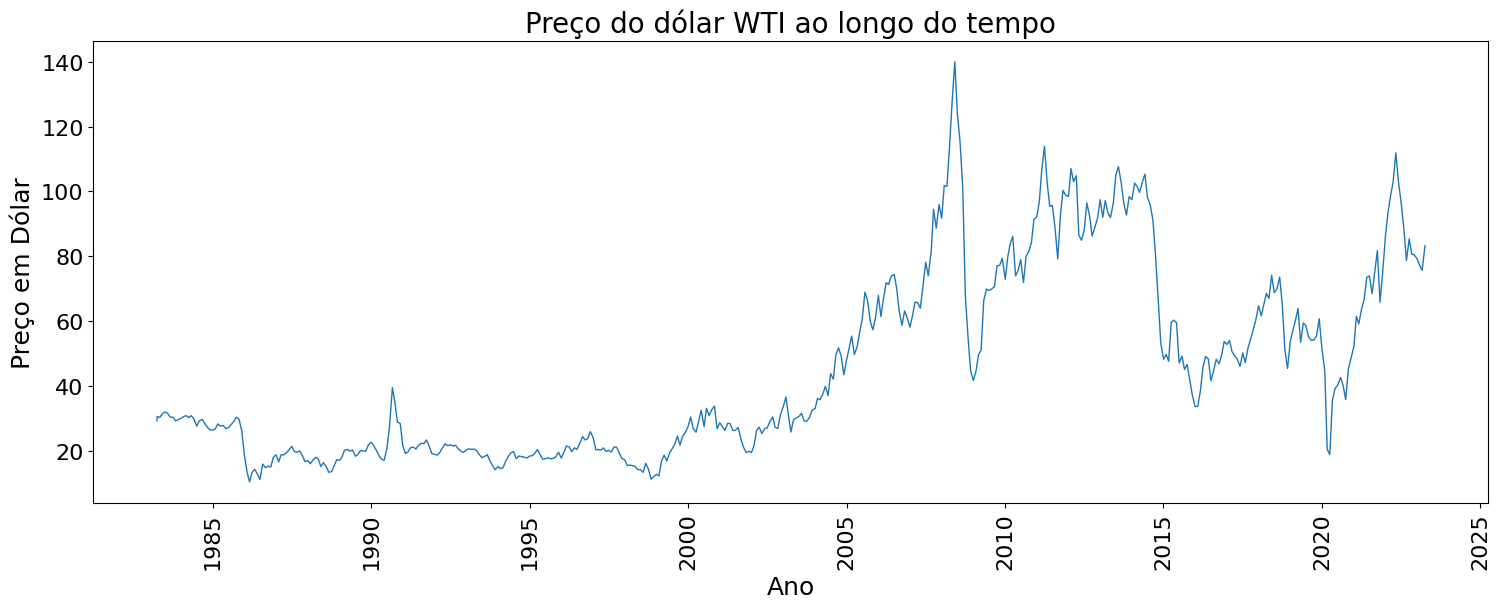

In [20]:
plt.figure(figsize=(18, 6))
plt.xticks(rotation=90)
sns.lineplot(data=df, x='date', y='price', lw=1)
ax = plt.gca()
ax.set_title('Preço do dólar WTI ao longo do tempo', fontsize=20)
ax.set_xlabel('Ano', fontsize=18)  # Set the X-axis label with fontsize 16
ax.set_ylabel('Preço em Dólar', fontsize=18)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.show()

In [21]:
#df_test.head(10)

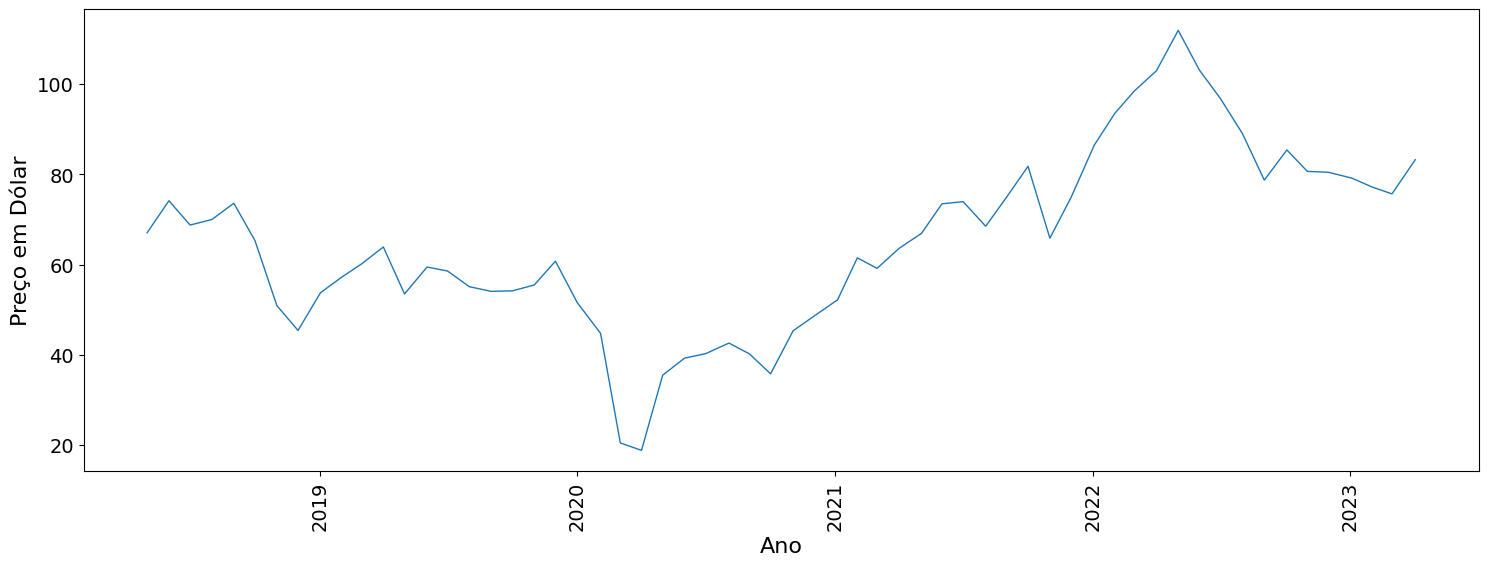

In [22]:
plt.figure(figsize=(18, 6))
plt.xticks(rotation=90)
sns.lineplot(data=df_test, x='date', y='price', lw=1)
ax = plt.gca()
ax.set_xlabel('Ano', fontsize=16)  # Set the X-axis label with fontsize 16
ax.set_ylabel('Preço em Dólar', fontsize=16)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
plt.show()

# EMD para Preço Normal:

In [23]:
df_input = None
t = None
s = None

df_input = pd.DataFrame()
df_input = df_train[['date', 'price']]
df_input['date'] = pd.to_datetime(df_input['date']).dt.strftime('%Y-%m')
df_input = df_input.set_index('date')
t = pd.to_datetime(df_input.index.values)
s = df_input['price'].values

In [24]:
%%time
# Execute a EMD
imfs_EMD_2 = None
emd = None

emd = EMD()
imfs_EMD_2 = emd(s)

CPU times: total: 31.2 ms
Wall time: 22.9 ms


In [25]:
%%time
# Execute a EMD
imfs_EEMD_2 = None
emd = None

emd = EEMD()
imfs_EEMD_2 = emd(s)

CPU times: total: 2.12 s
Wall time: 2.11 s


In [26]:
%%time
# Execute a EMD
imfs_CEEMDAN_2 = None
emd = None

emd = CEEMDAN()
imfs_CEEMDAN_2 = emd(s)

CPU times: total: 3.86 s
Wall time: 3.86 s


## Plot EMD

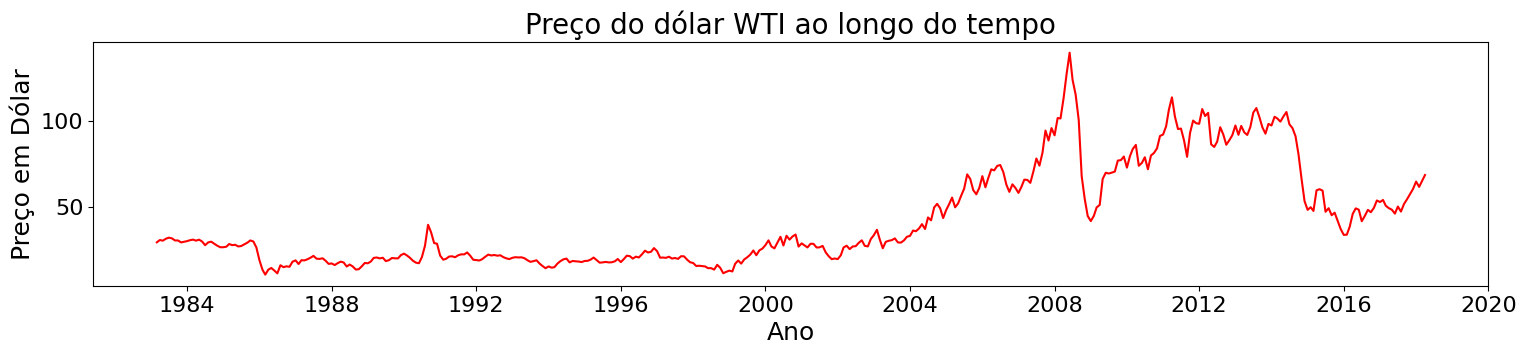

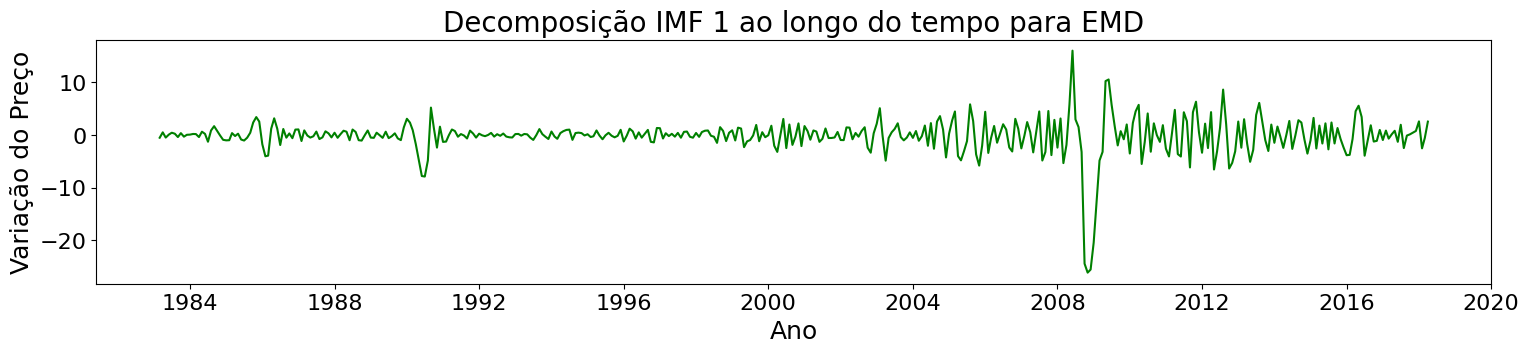

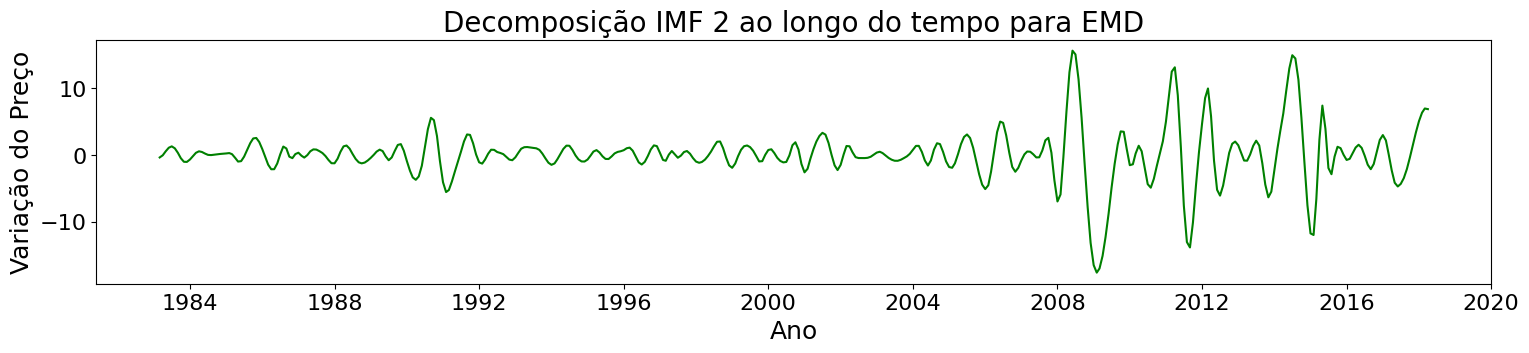

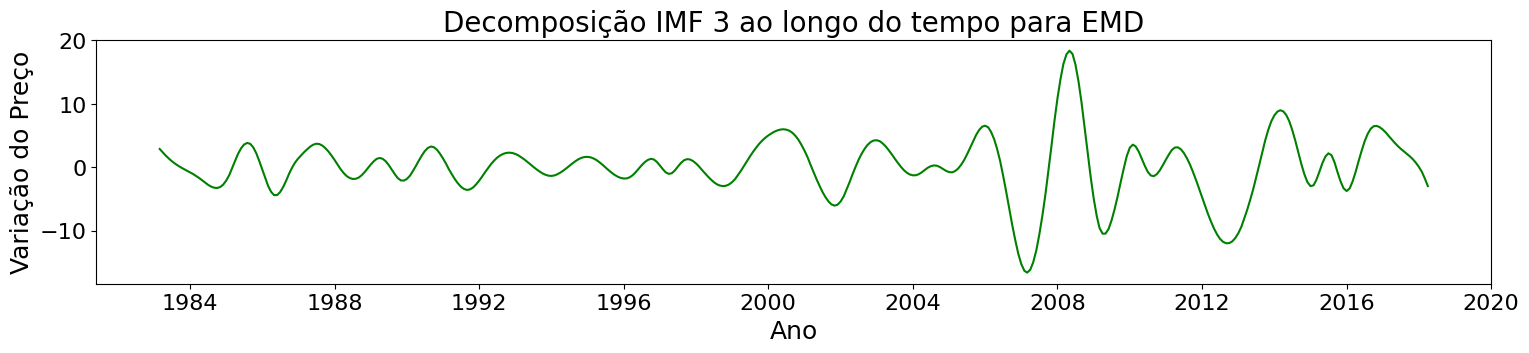

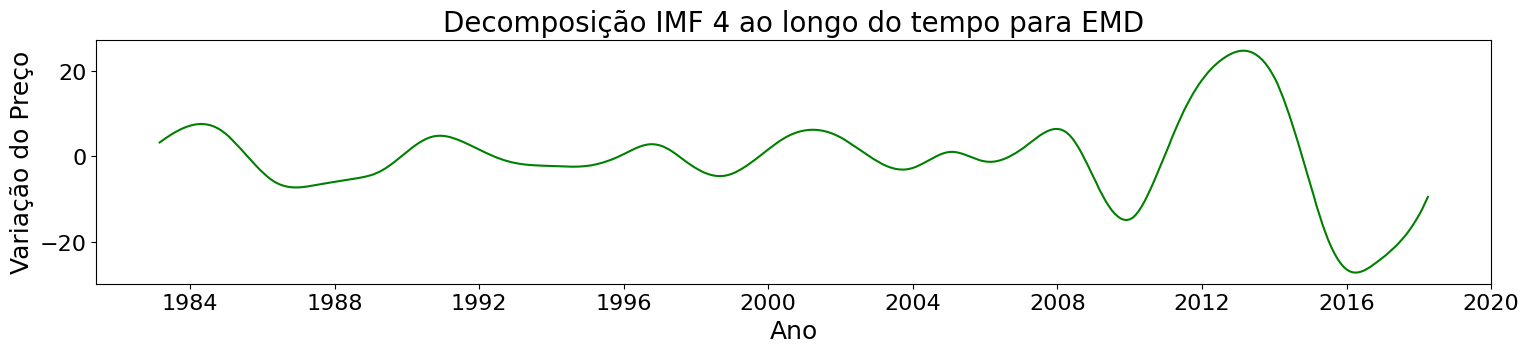

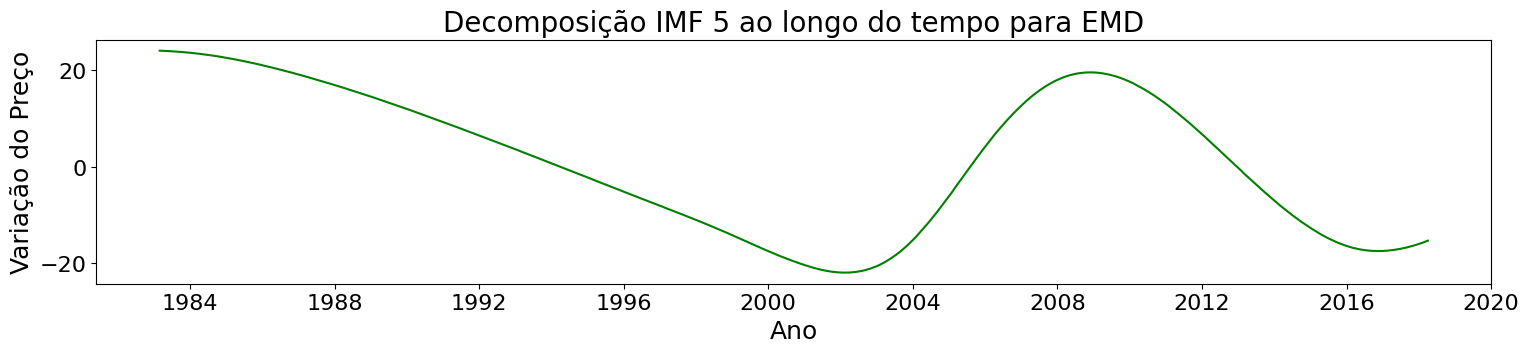

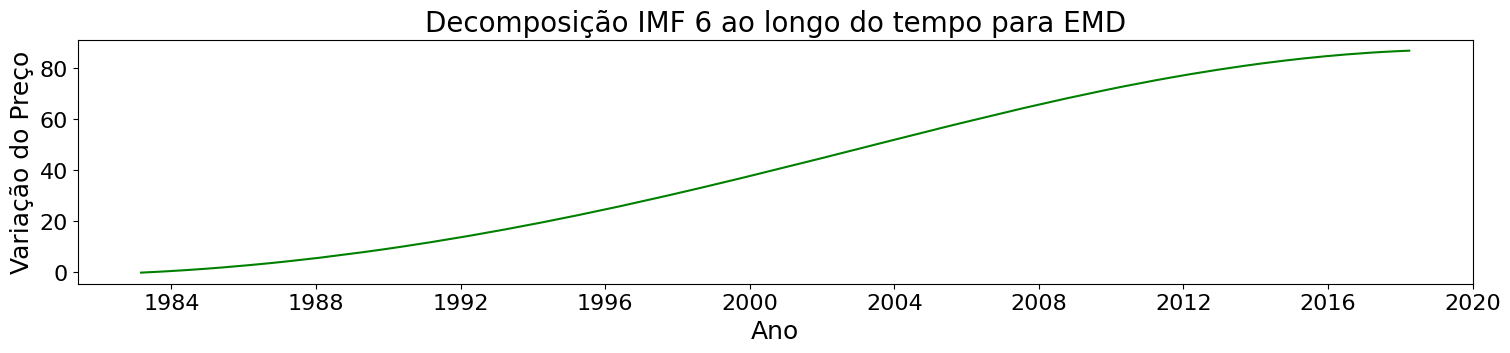

In [27]:
"Plot as IMFs"
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 26))

plt.subplot(imfs_EMD_2.shape[0]+1, 1, 1)
plt.plot(t, s, 'r')
ax = plt.gca()
ax.set_title('Preço do dólar WTI ao longo do tempo', fontsize=20)
ax.set_xlabel('Ano', fontsize=18)  # Set the X-axis label with fontsize 16
ax.set_ylabel('Preço em Dólar', fontsize=18)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.show()

for n, imf in enumerate(imfs_EMD_2):
    plt.figure(figsize=(18, 26))
    plt.subplot(imfs_EMD_2.shape[0]+1, 1, n+2)
    plt.plot(t, imf, 'g')
    ax = plt.gca()
    ax.set_title(f'Decomposição IMF {n+1} ao longo do tempo para EMD', fontsize=20)
    ax.set_xlabel('Ano', fontsize=18)  # Set the X-axis label with fontsize 16
    ax.set_ylabel('Variação do Preço', fontsize=18)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    plt.show()


## Plot EEMD

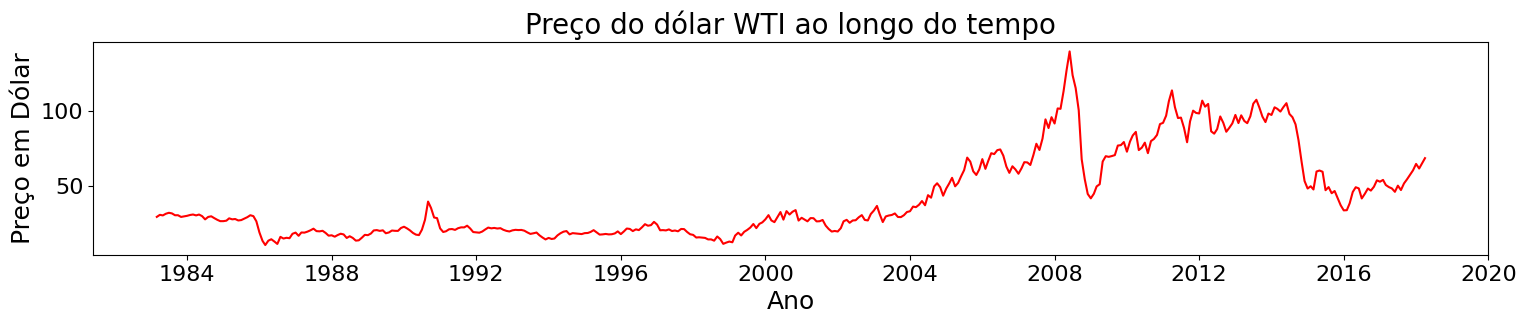

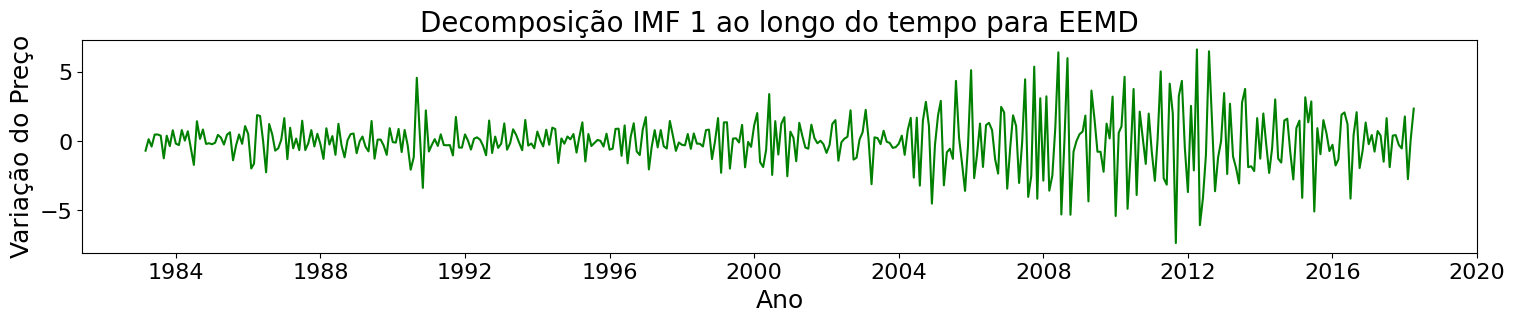

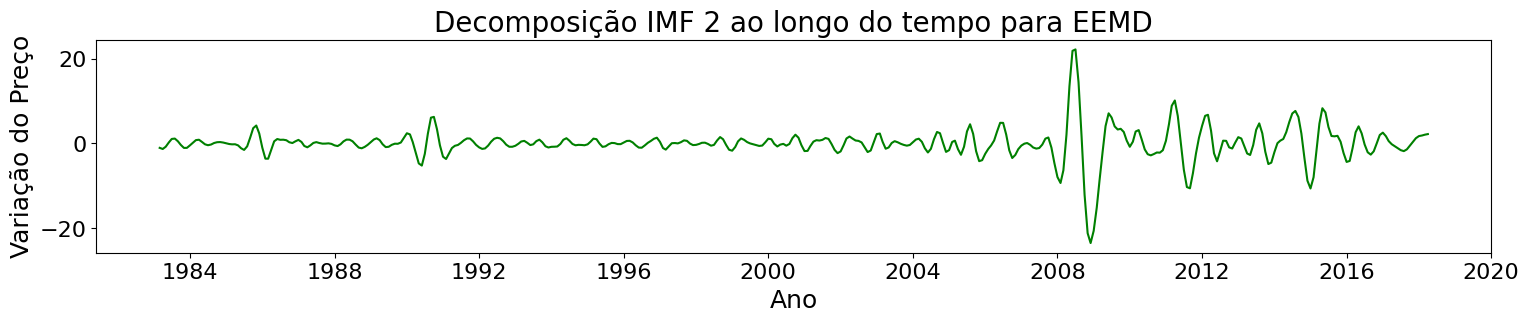

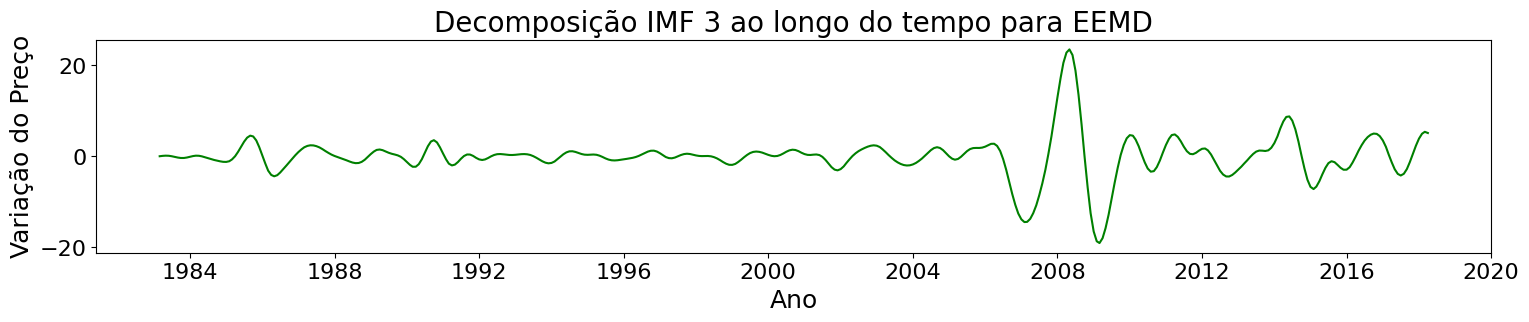

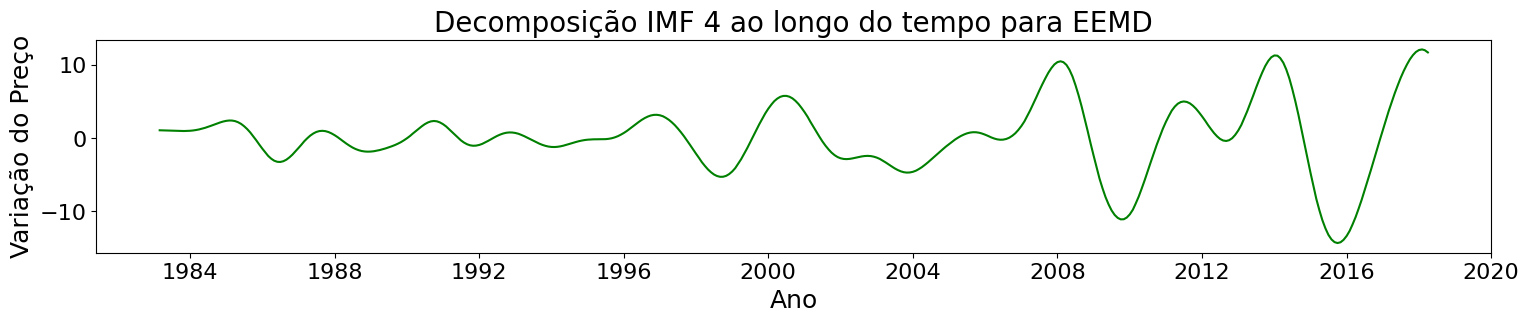

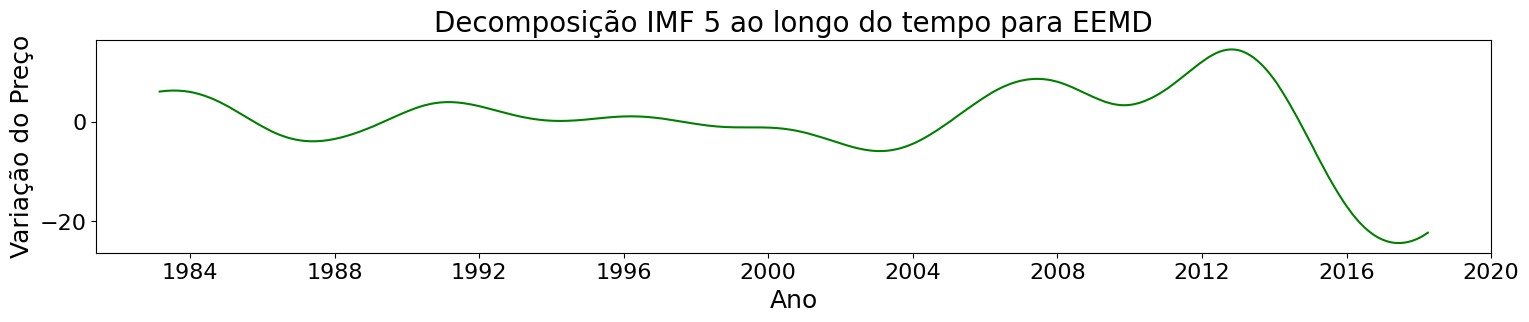

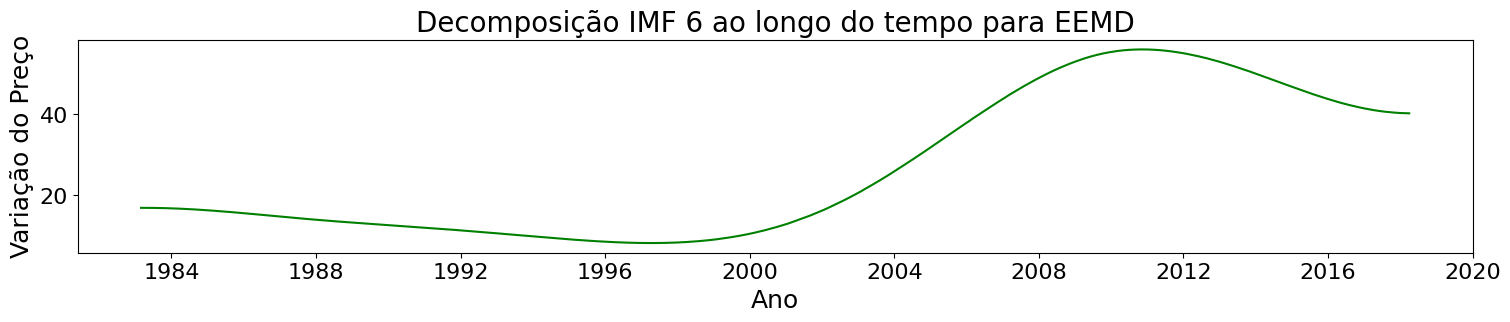

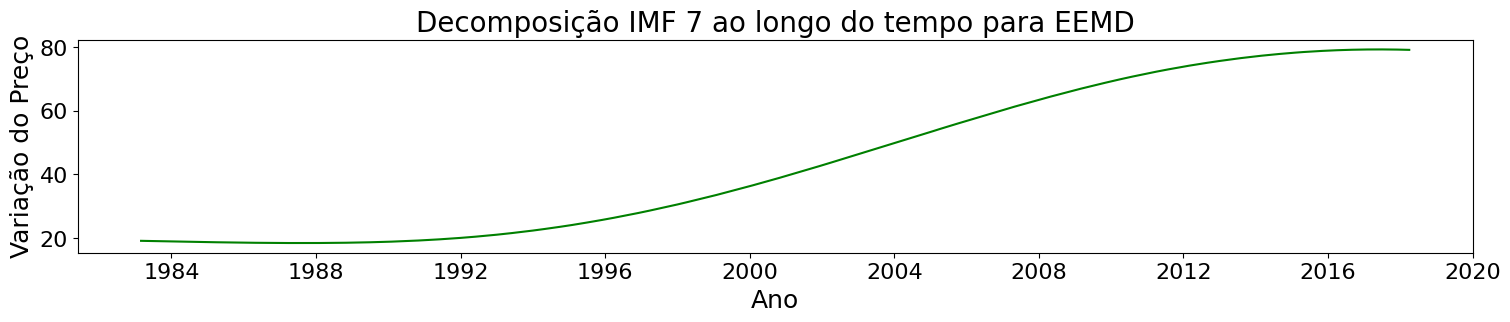

In [28]:
"Plot as IMFs"
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 26))

plt.subplot(imfs_EEMD_2.shape[0]+1, 1, 1)
plt.plot(t, s, 'r')
ax = plt.gca()
ax.set_title('Preço do dólar WTI ao longo do tempo', fontsize=20)
ax.set_xlabel('Ano', fontsize=18)  # Set the X-axis label with fontsize 16
ax.set_ylabel('Preço em Dólar', fontsize=18)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.show()

for n, imf in enumerate(imfs_EEMD_2):
    plt.figure(figsize=(18, 26))
    plt.subplot(imfs_EEMD_2.shape[0]+1, 1, n+2)
    plt.plot(t, imf, 'g')
    ax = plt.gca()
    ax.set_title(f'Decomposição IMF {n+1} ao longo do tempo para EEMD', fontsize=20)
    ax.set_xlabel('Ano', fontsize=18)  # Set the X-axis label with fontsize 16
    ax.set_ylabel('Variação do Preço', fontsize=18)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    plt.show()


## Plot CEEMDAN

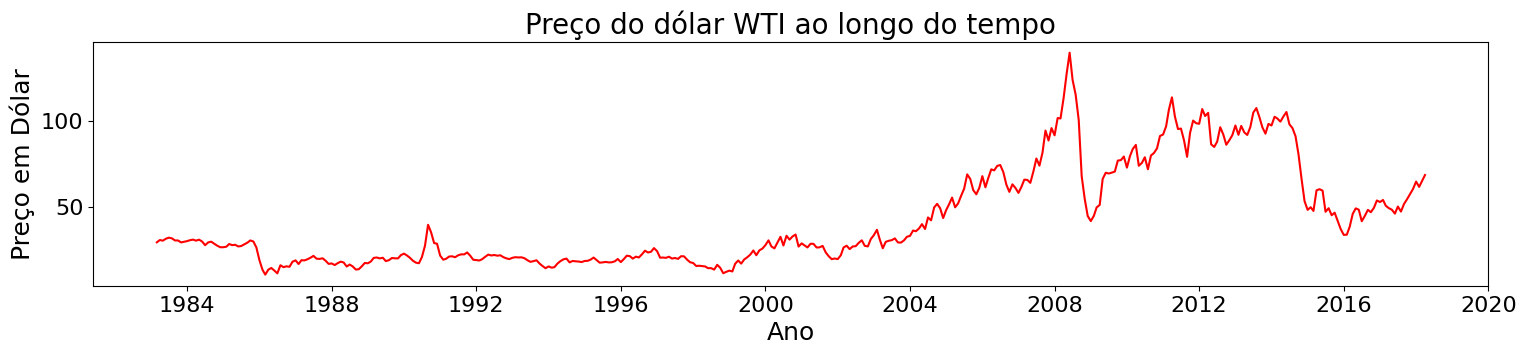

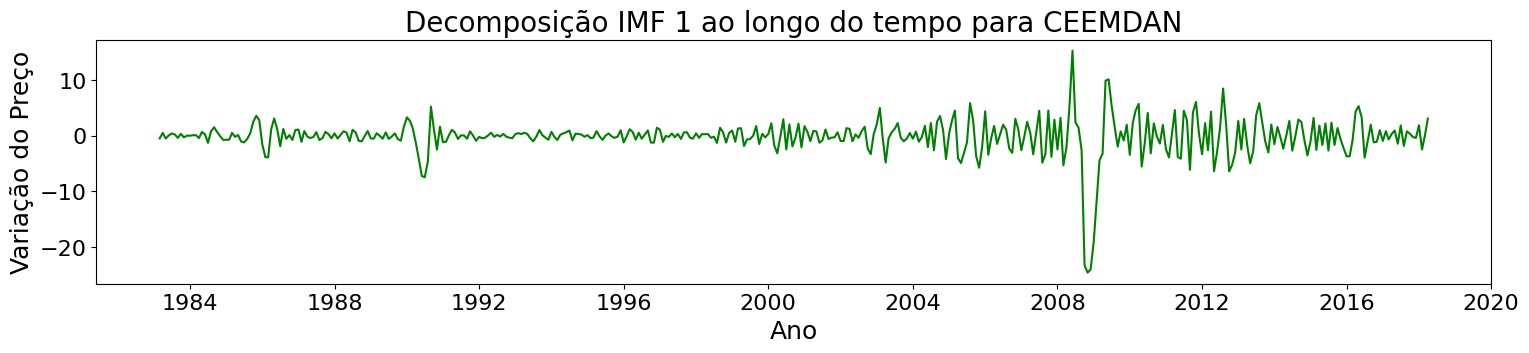

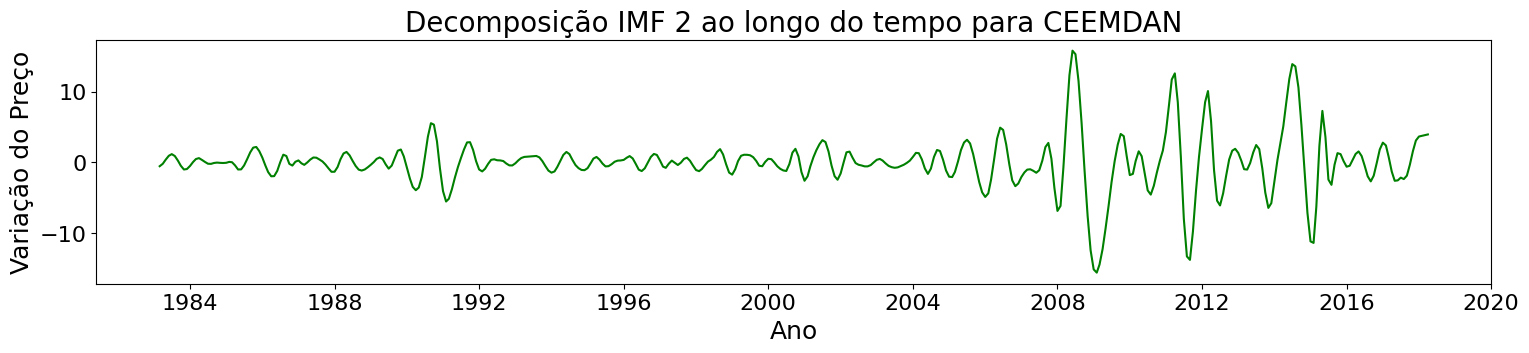

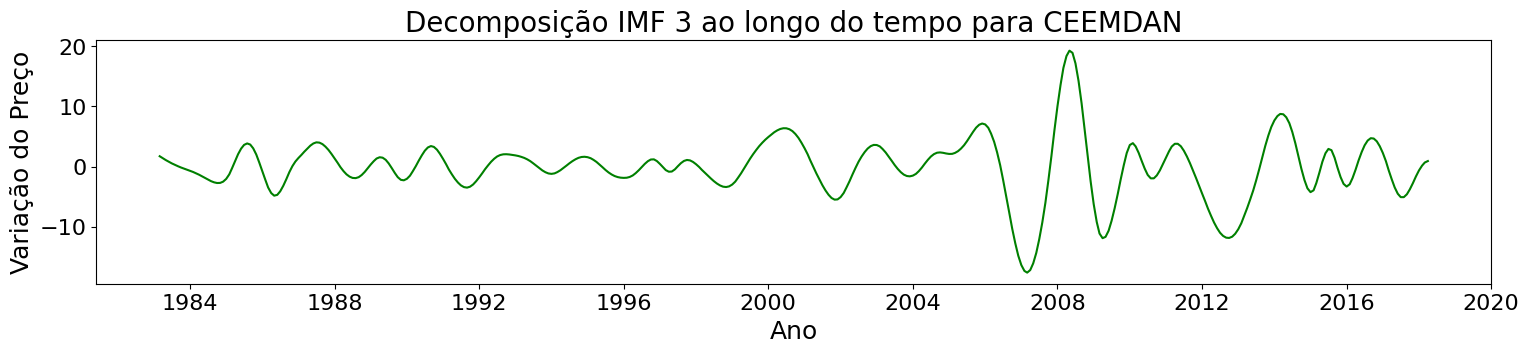

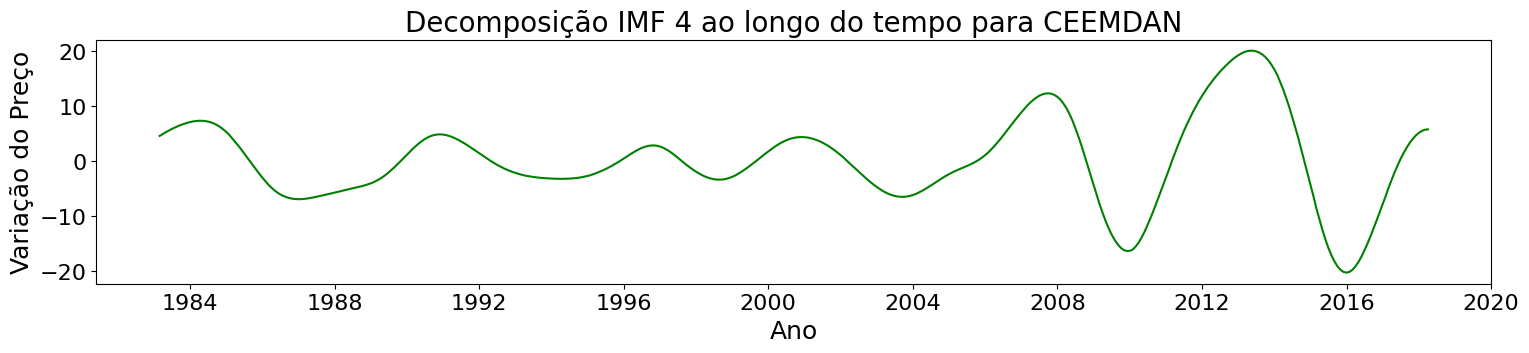

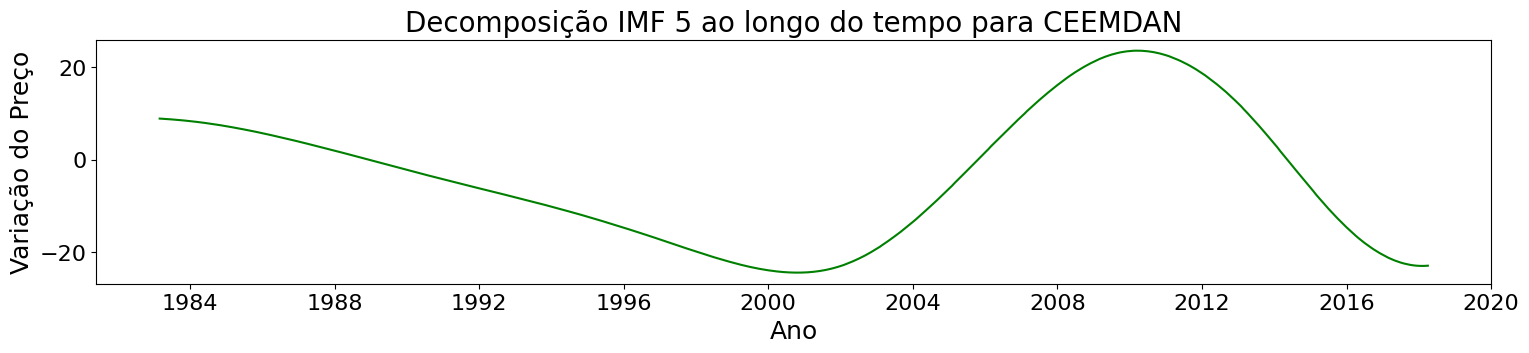

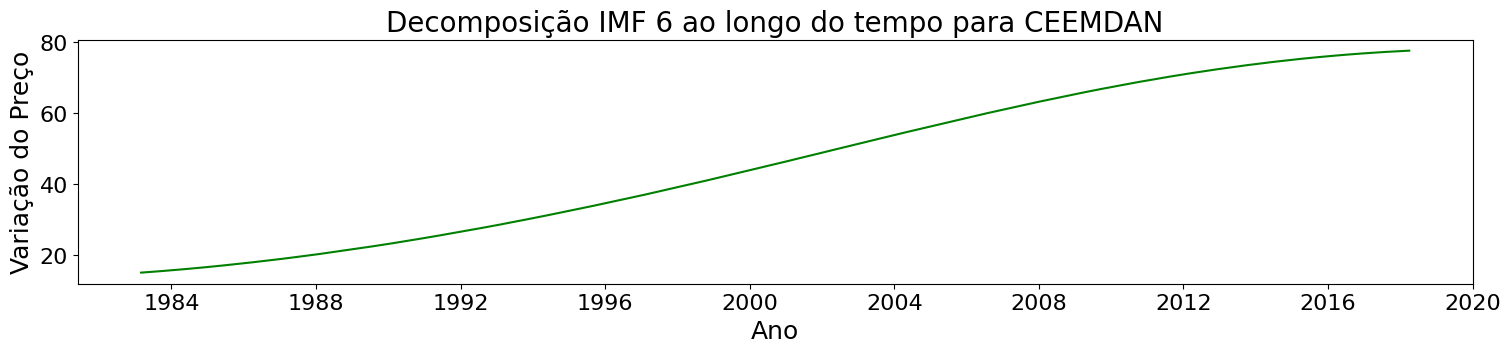

In [29]:
"Plot as IMFs"
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 26))

plt.subplot(imfs_CEEMDAN_2.shape[0]+1, 1, 1)
plt.plot(t, s, 'r')
ax = plt.gca()
ax.set_title('Preço do dólar WTI ao longo do tempo', fontsize=20)
ax.set_xlabel('Ano', fontsize=18)  # Set the X-axis label with fontsize 16
ax.set_ylabel('Preço em Dólar', fontsize=18)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.show()

for n, imf in enumerate(imfs_CEEMDAN_2):
    plt.figure(figsize=(18, 26))
    plt.subplot(imfs_CEEMDAN_2.shape[0]+1, 1, n+2)
    plt.plot(t, imf, 'g')
    ax = plt.gca()
    ax.set_title(f'Decomposição IMF {n+1} ao longo do tempo para CEEMDAN', fontsize=20)
    ax.set_xlabel('Ano', fontsize=18)  # Set the X-axis label with fontsize 16
    ax.set_ylabel('Variação do Preço', fontsize=18)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    plt.show()

# Estudo EMD

## Sarimax

In [30]:
%%time

MAPE_EMD_Sarimax_2 = pd.DataFrame(columns=['Name', 'MAPE_EMD_Sarimax'])

for n, imf in enumerate(imfs_EMD_2):
    df_func = None
    df_func = pd.DataFrame()
    df_func['Date'] = t
    df_func['Value'] = imf
    df_func = df_func.set_index('Date')
    _, MAPE = SARIMAX_EMD_FUNC(df_f=df_func)
    MAPE_EMD_Sarimax_2.loc[len(MAPE_EMD_Sarimax_2)] = [f'MAPE_{n+1}', MAPE]

C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency informa

CPU times: total: 3min 48s
Wall time: 3min 30s


## Prophet:

In [31]:
%%time

MAPE_EMD_Prophet_2 = pd.DataFrame(columns=['Name', 'MAPE_EMD_Prophet'])

for n, imf in enumerate(imfs_EMD_2):
    df_func = None
    df_func = pd.DataFrame()
    df_func['ds'] = t
    df_func['y'] = imf
    _, MAPE = PROPHET_EMD_FUNC(df_f=df_func)
    MAPE_EMD_Prophet_2.loc[len(MAPE_EMD_Prophet_2)] = [f'MAPE_{n+1}', MAPE]

11:14:19 - cmdstanpy - INFO - Chain [1] start processing
11:14:19 - cmdstanpy - INFO - Chain [1] done processing
11:14:19 - cmdstanpy - INFO - Chain [1] start processing
11:14:19 - cmdstanpy - INFO - Chain [1] done processing
11:14:20 - cmdstanpy - INFO - Chain [1] start processing
11:14:20 - cmdstanpy - INFO - Chain [1] done processing
11:14:20 - cmdstanpy - INFO - Chain [1] start processing
11:14:20 - cmdstanpy - INFO - Chain [1] done processing
11:14:20 - cmdstanpy - INFO - Chain [1] start processing
11:14:20 - cmdstanpy - INFO - Chain [1] done processing
11:14:21 - cmdstanpy - INFO - Chain [1] start processing
11:14:21 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 938 ms
Wall time: 2.39 s


## LASSO

In [32]:
%%time

MAPE_EMD_Lasso_2 = pd.DataFrame(columns=['Name', 'MAPE_EMD_Lasso'])

for n, imf in enumerate(imfs_EMD_2):
    df_func = None
    df_func = pd.DataFrame()
    df_func['Date'] = t
    df_func['Value'] = imf
    _, MAPE = LASSO_EMD_FUNC(df_f=df_func)
    MAPE_EMD_Lasso_2.loc[len(MAPE_EMD_Lasso_2)] = [f'MAPE_{n+1}', MAPE]

CPU times: total: 859 ms
Wall time: 853 ms


## Comparação dos 3 tipos de modelagem:

In [33]:
MAPE_temp = MAPE_EMD_Sarimax_2.merge(MAPE_EMD_Prophet_2, on='Name')

In [34]:
MAPE_EMD_2 = MAPE_temp.merge(MAPE_EMD_Lasso_2, on='Name')

In [35]:
MAPE_EMD_2.style.highlight_min(subset=['MAPE_EMD_Sarimax', 'MAPE_EMD_Prophet', 'MAPE_EMD_Lasso'],axis=1)

,Name,MAPE_EMD_Sarimax,MAPE_EMD_Prophet,MAPE_EMD_Lasso
0,MAPE_1,1.007248,1.610994,1.127244
1,MAPE_2,1.020217,2.205370,1.332800
2,MAPE_3,1.614434,2.659376,2.990757
3,MAPE_4,1.452276,1.251237,0.970075
4,MAPE_5,0.146104,3.071017,0.432301
5,MAPE_6,0.014457,0.044695,0.066059


## Previsão Futura EMD:

In [36]:
df_fut_EMD_res_2 = None
df_fut_EMD_res_2 = pd.DataFrame()
df_fut_EMD_res_2['Date'] = df_test['date'].reset_index(drop=True)

In [37]:
%%time

# Initialize a variable to store the column name with the largest value
largest_column = None
columns_to_sum_EMD_2 = []

# Iterate through each row in the DataFrame
for index, row in MAPE_EMD_2.iterrows():
    # Check which column has the largest value for the current row
    if row['MAPE_EMD_Sarimax'] < row['MAPE_EMD_Prophet'] and row['MAPE_EMD_Sarimax'] < row['MAPE_EMD_Lasso']:
        smallest_column = 'MAPE_EMD_Sarimax'
    elif row['MAPE_EMD_Prophet'] < row['MAPE_EMD_Sarimax'] and row['MAPE_EMD_Prophet'] < row['MAPE_EMD_Lasso']:
        smallest_column = 'MAPE_EMD_Prophet'
    elif row['MAPE_EMD_Lasso'] < row['MAPE_EMD_Sarimax'] and row['MAPE_EMD_Lasso'] < row['MAPE_EMD_Prophet']:
        smallest_column = 'MAPE_EMD_Lasso'

    # Perform your desired actions based on the largest column
    if smallest_column == 'MAPE_EMD_Sarimax':
        df_fut_EMD = None
        df_fut_EMD = pd.DataFrame()
        df_fut_EMD['Date'] = t
        df_fut_EMD['Value'] = imfs_EMD_2[index]
        df_fut_EMD = df_fut_EMD.set_index('Date')

        df_fut_EMD_res_2['EMD_'+str(index+1)] = SARIMAX_FUNC(df_fut_EMD).reset_index(drop=True)

    elif smallest_column == 'MAPE_EMD_Prophet':
        df_fut_EMD = None
        df_fut_EMD = pd.DataFrame()
        df_fut_EMD['ds'] = t
        df_fut_EMD['y'] = imfs_EMD_2[index]

        df_fut_EMD_res_2['EMD_'+str(index+1)] = PROPHET_FUNC(df_fut_EMD).reset_index(drop=True)

    elif smallest_column == 'MAPE_EMD_Lasso':
        df_fut_EMD = None
        df_fut_EMD = pd.DataFrame()
        df_fut_EMD['Date'] = t
        df_fut_EMD['Value'] = imfs_EMD_2[index]

        df_fut_EMD_res_2['EMD_'+str(index+1)] = LASSO_FUNC(df_fut_EMD)
    
    columns_to_sum_EMD_2.append('EMD_'+str(index+1)) 

C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency informa

CPU times: total: 3min 29s
Wall time: 3min 8s


In [38]:
df_fut_EMD_res_2['EMD_sum'] = df_fut_EMD_res_2[columns_to_sum_EMD_2].sum(axis=1)

In [39]:
df_final = None
df_final = pd.DataFrame()
df_final = df_test.reset_index(drop=True)

In [40]:
df_final['EMD'] = df_fut_EMD_res_2['EMD_sum'] 

# Estudo EEMD

## Sarimax

In [41]:
%%time

MAPE_EEMD_Sarimax_2 = pd.DataFrame(columns=['Name', 'MAPE_EEMD_Sarimax'])

for n, imf in enumerate(imfs_EEMD_2):
    df_func = None
    df_func = pd.DataFrame()
    df_func['Date'] = t
    df_func['Value'] = imf
    df_func = df_func.set_index('Date')
    _, MAPE = SARIMAX_EMD_FUNC(df_f=df_func)
    MAPE_EEMD_Sarimax_2.loc[len(MAPE_EEMD_Sarimax_2)] = [f'MAPE_{n+1}', MAPE]

C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency informa

CPU times: total: 3min 12s
Wall time: 3min 8s


C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Prophet

In [42]:
%%time

MAPE_EEMD_Prophet_2 = pd.DataFrame(columns=['Name', 'MAPE_EEMD_Prophet'])

for n, imf in enumerate(imfs_EEMD_2):
    df_func = None
    df_func = pd.DataFrame()
    df_func['ds'] = t
    df_func['y'] = imf
    _, MAPE = PROPHET_EMD_FUNC(df_f=df_func)
    MAPE_EEMD_Prophet_2.loc[len(MAPE_EEMD_Prophet_2)] = [f'MAPE_{n+1}', MAPE]

11:20:39 - cmdstanpy - INFO - Chain [1] start processing
11:20:39 - cmdstanpy - INFO - Chain [1] done processing
11:20:39 - cmdstanpy - INFO - Chain [1] start processing
11:20:39 - cmdstanpy - INFO - Chain [1] done processing
11:20:40 - cmdstanpy - INFO - Chain [1] start processing
11:20:40 - cmdstanpy - INFO - Chain [1] done processing
11:20:40 - cmdstanpy - INFO - Chain [1] start processing
11:20:40 - cmdstanpy - INFO - Chain [1] done processing
11:20:40 - cmdstanpy - INFO - Chain [1] start processing
11:20:40 - cmdstanpy - INFO - Chain [1] done processing
11:20:40 - cmdstanpy - INFO - Chain [1] start processing
11:20:40 - cmdstanpy - INFO - Chain [1] done processing
11:20:41 - cmdstanpy - INFO - Chain [1] start processing
11:20:41 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 1.03 s
Wall time: 2.14 s


## LASSO

In [43]:
%%time

MAPE_EEMD_Lasso_2 = pd.DataFrame(columns=['Name', 'MAPE_EEMD_Lasso'])

for n, imf in enumerate(imfs_EEMD_2):
    df_func = None
    df_func = pd.DataFrame()
    df_func['Date'] = t
    df_func['Value'] = imf
    _, MAPE = LASSO_EMD_FUNC(df_f=df_func)
    MAPE_EEMD_Lasso_2.loc[len(MAPE_EEMD_Lasso_2)] = [f'MAPE_{n+1}', MAPE]

CPU times: total: 984 ms
Wall time: 975 ms


## Comparação dos 3 tipos de modelagem:

In [44]:
MAPE_temp = MAPE_EEMD_Sarimax_2.merge(MAPE_EEMD_Prophet_2, on='Name')

In [45]:
MAPE_EEMD_2 = MAPE_temp.merge(MAPE_EEMD_Lasso_2, on='Name')

In [46]:
MAPE_EEMD_2.style.highlight_min(subset=['MAPE_EEMD_Sarimax', 'MAPE_EEMD_Prophet', 'MAPE_EEMD_Lasso'],axis=1)

,Name,MAPE_EEMD_Sarimax,MAPE_EEMD_Prophet,MAPE_EEMD_Lasso
0,MAPE_1,0.978501,0.985298,0.993192
1,MAPE_2,1.188172,2.446278,1.554818
2,MAPE_3,1.086152,1.232303,1.084737
3,MAPE_4,0.996248,0.997986,0.817088
4,MAPE_5,0.299023,2.683857,2.899201
5,MAPE_6,0.003608,0.404397,0.321238
6,MAPE_7,0.000788,0.066398,0.102304


## Previsão Futura EEMD:

In [47]:
df_fut_EEMD_res_2 = None
df_fut_EEMD_res_2 = pd.DataFrame()
df_fut_EEMD_res_2['Date'] = df_test['date'].reset_index(drop=True)

In [48]:
%%time

# Initialize a variable to store the column name with the largest value
largest_column = None
columns_to_sum_EEMD_2 = []

# Iterate through each row in the DataFrame
for index, row in MAPE_EEMD_2.iterrows():
    # Check which column has the largest value for the current row
    if row['MAPE_EEMD_Sarimax'] < row['MAPE_EEMD_Prophet'] and row['MAPE_EEMD_Sarimax'] < row['MAPE_EEMD_Lasso']:
        smallest_column = 'MAPE_EEMD_Sarimax'
    elif row['MAPE_EEMD_Prophet'] < row['MAPE_EEMD_Sarimax'] and row['MAPE_EEMD_Prophet'] < row['MAPE_EEMD_Lasso']:
        smallest_column = 'MAPE_EEMD_Prophet'
    elif row['MAPE_EEMD_Lasso'] < row['MAPE_EEMD_Sarimax'] and row['MAPE_EEMD_Lasso'] < row['MAPE_EEMD_Prophet']:
        smallest_column = 'MAPE_EEMD_Lasso'

    # Perform your desired actions based on the largest column
    if smallest_column == 'MAPE_EEMD_Sarimax':
        df_fut_EEMD = None
        df_fut_EEMD = pd.DataFrame()
        df_fut_EEMD['Date'] = t
        df_fut_EEMD['Value'] = imfs_EEMD_2[index]
        df_fut_EEMD = df_fut_EEMD.set_index('Date')

        df_fut_EEMD_res_2['EEMD_'+str(index+1)] = SARIMAX_FUNC(df_fut_EEMD).reset_index(drop=True)

    elif smallest_column == 'MAPE_EEMD_Prophet':
        df_fut_EEMD = None
        df_fut_EEMD = pd.DataFrame()
        df_fut_EEMD['ds'] = t
        df_fut_EEMD['y'] = imfs_EEMD_2[index]

        df_fut_EEMD_res_2['EEMD_'+str(index+1)] = PROPHET_FUNC(df_fut_EEMD).reset_index(drop=True)

    elif smallest_column == 'MAPE_EEMD_Lasso':
        df_fut_EEMD = None
        df_fut_EEMD = pd.DataFrame()
        df_fut_EEMD['Date'] = t
        df_fut_EEMD['Value'] = imfs_EEMD_2[index]

        df_fut_EEMD_res_2['EEMD_'+str(index+1)] = LASSO_FUNC(df_fut_EEMD)
    
    columns_to_sum_EEMD_2.append('EEMD_'+str(index+1)) 

C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency informa

CPU times: total: 1min 16s
Wall time: 1min 19s


C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [49]:
df_fut_EEMD_res_2[columns_to_sum_EEMD_2]

,EEMD_1,EEMD_2,EEMD_3,EEMD_4,EEMD_5,EEMD_6,EEMD_7
0,-5.101302e-01,1.651346,4.600173,11.164954,-21.859870,40.274285,79.171686
1,-8.627467e-01,0.299230,3.728321,10.498601,-21.387325,40.278553,79.146092
2,-1.033099e-01,-1.257752,2.668332,9.689590,-20.880615,40.293217,79.120498
3,3.255018e-01,-2.238079,1.462530,8.755016,-20.342148,40.318157,79.094904
4,1.636362e-01,-2.318771,0.234113,7.716548,-19.774527,40.353238,79.069310
5,-7.681394e-02,-1.716166,-0.937066,6.602580,-19.180518,40.398303,79.043716
6,-9.730777e-02,-0.858114,-1.962454,5.434438,-18.563022,40.453188,79.018122
7,-3.527472e-03,-0.063860,-2.779488,4.234613,-17.925034,40.517737,78.992528
8,3.971043e-02,0.536164,-3.340607,3.025862,-17.269620,40.591787,78.966934
9,1.613796e-02,0.909216,-3.622671,1.830214,-16.599878,40.675129,78.941340


In [50]:
df_fut_EEMD_res_2['EEMD_sum'] = df_fut_EEMD_res_2[columns_to_sum_EEMD_2].sum(axis=1)

In [51]:
df_final['EEMD'] = df_fut_EEMD_res_2['EEMD_sum'] 

# Estudo CEEMDAN

## Sarimax

In [52]:
%%time

MAPE_CEEMDAN_Sarimax_2 = pd.DataFrame(columns=['Name', 'MAPE_CEEMDAN_Sarimax'])

for n, imf in enumerate(imfs_CEEMDAN_2):
    df_func = None
    df_func = pd.DataFrame()
    df_func['Date'] = t
    df_func['Value'] = imf
    df_func = df_func.set_index('Date')
    _, MAPE = SARIMAX_EMD_FUNC(df_f=df_func)
    MAPE_CEEMDAN_Sarimax_2.loc[len(MAPE_CEEMDAN_Sarimax_2)] = [f'MAPE_{n+1}', MAPE]

C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency informa

CPU times: total: 2min 58s
Wall time: 2min 44s


C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Prophet

In [53]:
%%time

MAPE_CEEMDAN_Prophet_2 = pd.DataFrame(columns=['Name', 'MAPE_CEEMDAN_Prophet'])

for n, imf in enumerate(imfs_CEEMDAN_2):
    df_func = None
    df_func = pd.DataFrame()
    df_func['ds'] = t
    df_func['y'] = imf
    _, MAPE = PROPHET_EMD_FUNC(df_f=df_func)
    MAPE_CEEMDAN_Prophet_2.loc[len(MAPE_CEEMDAN_Prophet_2)] = [f'MAPE_{n+1}', MAPE]

11:24:47 - cmdstanpy - INFO - Chain [1] start processing
11:24:47 - cmdstanpy - INFO - Chain [1] done processing
11:24:47 - cmdstanpy - INFO - Chain [1] start processing
11:24:47 - cmdstanpy - INFO - Chain [1] done processing
11:24:47 - cmdstanpy - INFO - Chain [1] start processing
11:24:47 - cmdstanpy - INFO - Chain [1] done processing
11:24:48 - cmdstanpy - INFO - Chain [1] start processing
11:24:48 - cmdstanpy - INFO - Chain [1] done processing
11:24:48 - cmdstanpy - INFO - Chain [1] start processing
11:24:48 - cmdstanpy - INFO - Chain [1] done processing
11:24:48 - cmdstanpy - INFO - Chain [1] start processing
11:24:48 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 922 ms
Wall time: 1.95 s


## LASSO

In [54]:
%%time

MAPE_CEEMDAN_Lasso_2 = pd.DataFrame(columns=['Name', 'MAPE_CEEMDAN_Lasso'])

for n, imf in enumerate(imfs_CEEMDAN_2):
    df_func = None
    df_func = pd.DataFrame()
    df_func['Date'] = t
    df_func['Value'] = imf
    _, MAPE = LASSO_EMD_FUNC(df_f=df_func)
    MAPE_CEEMDAN_Lasso_2.loc[len(MAPE_CEEMDAN_Lasso_2)] = [f'MAPE_{n+1}', MAPE]

CPU times: total: 812 ms
Wall time: 808 ms


## Comparação dos 3 tipos de modelagem:

In [55]:
MAPE_temp = MAPE_CEEMDAN_Sarimax_2.merge(MAPE_CEEMDAN_Prophet_2, on='Name')

In [56]:
MAPE_CEEMDAN_2 = MAPE_temp.merge(MAPE_CEEMDAN_Lasso_2, on='Name')

In [57]:
MAPE_CEEMDAN_2.style.highlight_min(subset=['MAPE_CEEMDAN_Sarimax', 'MAPE_CEEMDAN_Prophet', 'MAPE_CEEMDAN_Lasso'],axis=1)

,Name,MAPE_CEEMDAN_Sarimax,MAPE_CEEMDAN_Prophet,MAPE_CEEMDAN_Lasso
0,MAPE_1,1.191166,8.687742,3.251202
1,MAPE_2,1.062557,1.426412,1.158312
2,MAPE_3,1.428824,1.692878,1.467788
3,MAPE_4,7.921638,2.302581,3.691971
4,MAPE_5,0.029896,8.830375,1.706005
5,MAPE_6,0.000108,0.032960,0.046337


## Previsão Futura CEEMDAN:

In [58]:
df_fut_CEEMDAN_res_2 = None
df_fut_CEEMDAN_res_2 = pd.DataFrame()
df_fut_CEEMDAN_res_2['Date'] = df_test['date'].reset_index(drop=True)

In [59]:
%%time

# Initialize a variable to store the column name with the largest value
largest_column = None
columns_to_sum_CEEMDAN_2 = []

# Iterate through each row in the DataFrame
for index, row in MAPE_CEEMDAN_2.iterrows():
    # Check which column has the largest value for the current row
    if row['MAPE_CEEMDAN_Sarimax'] < row['MAPE_CEEMDAN_Prophet'] and row['MAPE_CEEMDAN_Sarimax'] < row['MAPE_CEEMDAN_Lasso']:
        smallest_column = 'MAPE_CEEMDAN_Sarimax'
    elif row['MAPE_CEEMDAN_Prophet'] < row['MAPE_CEEMDAN_Sarimax'] and row['MAPE_CEEMDAN_Prophet'] < row['MAPE_CEEMDAN_Lasso']:
        smallest_column = 'MAPE_CEEMDAN_Prophet'
    elif row['MAPE_CEEMDAN_Lasso'] < row['MAPE_CEEMDAN_Sarimax'] and row['MAPE_CEEMDAN_Lasso'] < row['MAPE_CEEMDAN_Prophet']:
        smallest_column = 'MAPE_CEEMDAN_Lasso'

    # Perform your desired actions based on the largest column
    if smallest_column == 'MAPE_CEEMDAN_Sarimax':
        df_fut_CEEMDAN = None
        df_fut_CEEMDAN = pd.DataFrame()
        df_fut_CEEMDAN['Date'] = t
        df_fut_CEEMDAN['Value'] = imfs_CEEMDAN_2[index]
        df_fut_CEEMDAN = df_fut_CEEMDAN.set_index('Date')

        df_fut_CEEMDAN_res_2['CEEMDAN_'+str(index+1)] = SARIMAX_FUNC(df_fut_CEEMDAN).reset_index(drop=True)

    elif smallest_column == 'MAPE_CEEMDAN_Prophet':
        df_fut_CEEMDAN = None
        df_fut_CEEMDAN = pd.DataFrame()
        df_fut_CEEMDAN['ds'] = t
        df_fut_CEEMDAN['y'] = imfs_CEEMDAN_2[index]

        df_fut_CEEMDAN_res_2['CEEMDAN_'+str(index+1)] = PROPHET_FUNC(df_fut_CEEMDAN).reset_index(drop=True)

    elif smallest_column == 'MAPE_CEEMDAN_Lasso':
        df_fut_CEEMDAN = None
        df_fut_CEEMDAN = pd.DataFrame()
        df_fut_CEEMDAN['Date'] = t
        df_fut_CEEMDAN['Value'] = imfs_CEEMDAN_2[index]

        df_fut_CEEMDAN_res_2['CEEMDAN_'+str(index+1)] = LASSO_FUNC(df_fut_CEEMDAN)
    
    columns_to_sum_CEEMDAN_2.append('CEEMDAN_'+str(index+1)) 

C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\GAMER\anaconda3\envs\Estudo\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood opt

CPU times: total: 2min 48s
Wall time: 2min 42s


In [60]:
df_fut_CEEMDAN_res_2[columns_to_sum_CEEMDAN_2]

,CEEMDAN_1,CEEMDAN_2,CEEMDAN_3,CEEMDAN_4,CEEMDAN_5,CEEMDAN_6
0,1.590781e+00,3.415698,0.894828,0.105709,-22.784437,77.708698
1,6.669350e-01,2.040533,0.675306,0.148744,-22.683823,77.745831
2,1.337597e-01,0.169198,0.343691,0.129848,-22.553598,77.781533
3,-1.423308e-01,-1.569132,-0.015951,0.152137,-22.393794,77.815802
4,-2.586575e-01,-2.671106,-0.332119,0.171110,-22.204467,77.848634
5,-2.826555e-01,-3.014595,-0.555903,0.132183,-21.985704,77.880027
6,-2.587385e-01,-2.701964,-0.664680,0.150696,-21.737621,77.909978
7,-2.145344e-01,-1.989907,-0.660313,0.124198,-21.460365,77.938485
8,-1.660312e-01,-1.135314,-0.563429,0.157382,-21.154114,77.965544
9,-1.215441e-01,-0.353547,-0.405721,0.210549,-20.819079,77.991154


In [61]:
df_fut_CEEMDAN_res_2['CEEMDAN_sum'] = df_fut_CEEMDAN_res_2[columns_to_sum_CEEMDAN_2].sum(axis=1)

In [62]:
df_final['CEEMDAN'] = df_fut_CEEMDAN_res_2['CEEMDAN_sum'] 

# Comparação:

In [63]:
df_final["ORIGINAL"] = df_final["price"]

In [64]:
df_long = pd.melt(df_final, 
                  id_vars=['date'], 
                  value_vars=['ORIGINAL','EMD','EEMD','CEEMDAN'], 
                  var_name='Dados:', value_name='ORIGINAL')

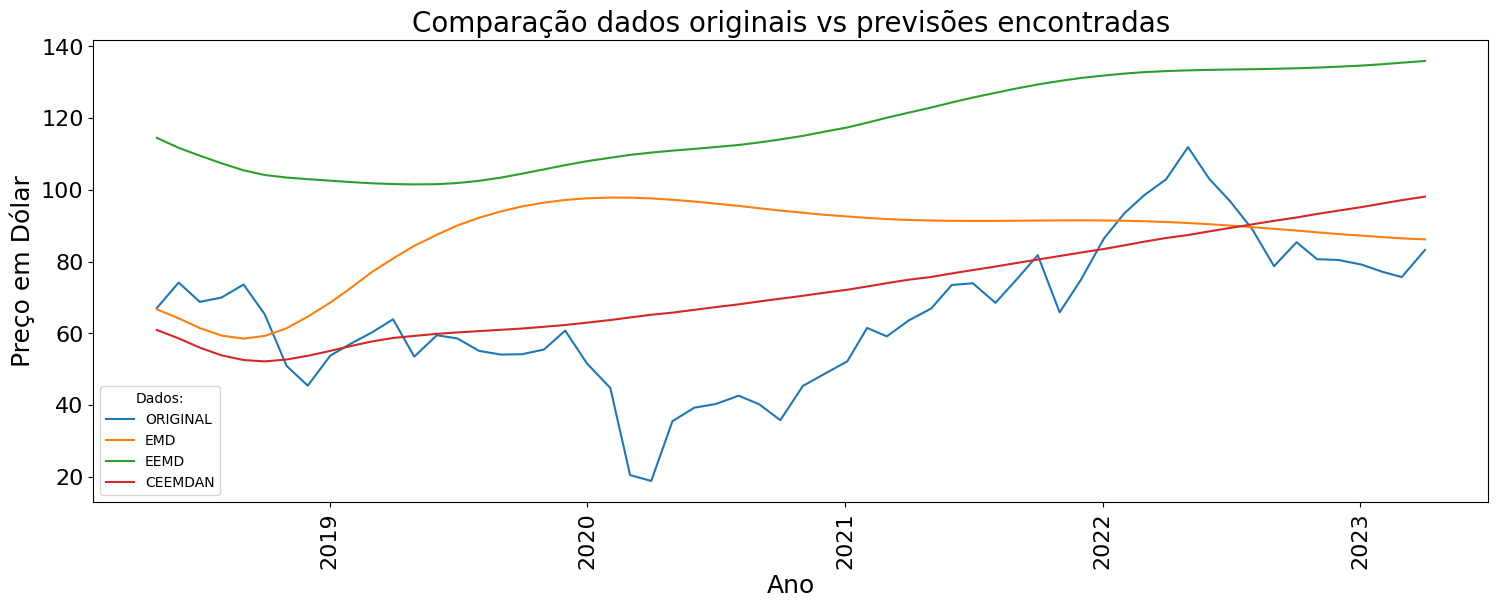

In [95]:
plt.figure(figsize=(18, 6))
plt.xticks(rotation=90)
sns.lineplot(data=df_long, x='date', y='ORIGINAL', hue='Dados:')
ax = plt.gca()
ax.set_title(f'Comparação dados originais vs previsões encontradas', fontsize=20)
ax.set_xlabel('Ano', fontsize=18)  # Set the X-axis label with fontsize 16
ax.set_ylabel('Preço em Dólar', fontsize=18)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.show()

In [83]:
correlation_EMD = df_final['price'].corr(df_final['EMD'])

In [84]:
mape_EMD = np.mean(np.abs(df_final['EMD'] - df_final['price'])/np.abs(df_final['price']))

In [85]:
correlation_EEMD = df_final['price'].corr(df_final['EEMD'])

In [86]:
mape_EEMD = np.mean(np.abs(df_final['EEMD'] - df_final['price'])/np.abs(df_final['price']))

In [87]:
correlation_CEEMDAN = df_final['price'].corr(df_final['CEEMDAN'])

In [88]:
mape_CEEMDAN = np.mean(np.abs(df_final['CEEMDAN'] - df_final['price'])/np.abs(df_final['price']))

In [94]:
df_final['price'].corr(df_final['price'])

1.0

In [93]:
np.mean(np.abs(df_final['price'] - df_final['price'])/np.abs(df_final['price']))

0.0

In [89]:
df_final[-1:]

,date,price,EMD,EEMD,CEEMDAN,ORIGINAL
59,2023-04-03,83.2407,86.188041,135.92225,98.103108,83.2407


In [92]:
print(f"Correlação EMD: {round(correlation_EMD, 4)}.")
print(f"MAPE EMD: {round(mape_EMD, 4)}.")
print(f"Correlação EEMD: {round(correlation_EEMD, 4)}.")
print(f"MAPE EEMD: {round(mape_EEMD, 4)}.")
print(f"Correlação CEEMDAN: {round(correlation_CEEMDAN, 4)}.")
print(f"MAPE CEEMDAN: {round(mape_CEEMDAN, 4)}.")

Correlação EMD: -0.1262.
MAPE EMD: 0.5694.
Correlação EEMD: 0.706.
MAPE EEMD: 1.001.
Correlação CEEMDAN: 0.6323.
MAPE CEEMDAN: 0.2852.
